# Plot Scratchpad Results

## Prerequisites

In [44]:
import copy
import datetime
import importlib
import re

from pathlib import Path

import numpy as np
from tqdm import tqdm

import plotnine as p9

import pandas as pd
from collections import deque

from utils import add_src_to_sys_path

add_src_to_sys_path()

from common import wandb_utils, nest
from common import plotnine_utils as p9u

wandb_utils = importlib.reload(wandb_utils)
p9u = importlib.reload(p9u)

## Load the experiments

In [2]:
tags = ["showcase_final"]

In [3]:
plot_dir_name = "__".join(tags)
output_dir = Path("output_plots") / f"{plot_dir_name}"
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
df_sanity_check = wandb_utils.download_and_load_results(
    tags=["sanity_check"],
    force_download=False,
)
len(df_sanity_check)

401

In [5]:
df_classic = wandb_utils.download_and_load_results(
    tags=["classic"],
    force_download=False,
)
len(df_classic)

136

In [6]:
df_scratchpad = wandb_utils.download_and_load_results(
    tags=["scratchpad_f"],
    force_download=False,
)
len(df_scratchpad)

1635

In [7]:
scratchpad_config_pattern = re.compile(r"(.)*_scratchpad(.)+_ufs__(i._c._o._v._r.)_.*___.*")

overall_acc_pattern = re.compile(r"pred\/(\w+)_acc_(.+)")
scratchpad_acc_pattern = re.compile(r"pred\/(\w+)__(\w+)_([\w\[\],\s]+)")


def get_split(key: str) -> str:
    if "test" in key:
        return "test"
    elif "valid" in key:
        return "validation"
    else:
        raise ValueError()


def get_category(ds, ds_split, key: str) -> int:
    if key == "overall":
        return -1
    if "-by-" in key:
        a, b = key.split("-by-")
        a, b = int(a), int(b)
        return max(a, b)
    if "[" in key and "]" in key and "," in key:
        return int(key.split("[")[1].split("]")[0].split(",")[0])
    else:
        return int(key)


def get_category(ds, ds_split, key: str) -> int:
    if key == "overall":
        return -1
    if "-by-" in key:
        a, b = key.split("-by-")
        a, b = int(a), int(b)
        return max(a, b)
    if "[" in key and "]" in key and "," in key:
        return int(key.split("[")[1].split("]")[0].split(",")[0])
    else:
        return int(key)


df = pd.concat([df_sanity_check, df_classic, df_scratchpad])

xdf_data = deque()
for i, row in tqdm(df.iterrows(), total=len(df)):
    if row["job_type"] != "best_run_seed_exp":
        continue

    group = row["run_group"]

    scratchpad_config = "no_scratchpad"
    result = scratchpad_config_pattern.search(group)
    if result:
        scratchpad_config = result.group(3)

    dataset_name = row["cfg__dataset.name"]
    dataset_split = row["cfg__dataset.split"]
    dataset_pretty = wandb_utils.get_pretty_dataset_name(dataset_name, dataset_split)

    pe_name = wandb_utils.get_pretty_pe_name(row["cfg__model.position_encoding_type"])

    # Overall Accuracy
    for k, v in row.items():
        if np.all(pd.isnull(v)):
            continue

        if k.startswith("sum__pred/"):
            prediction_split = get_split(k)
            if "_acc_" in k:
                o = overall_acc_pattern.search(k)
                category = o.group(2)
                length = get_category(dataset_name, dataset_split, category)
                metric = "output_acc"
            else:
                k2 = k.replace("__overall", "_overall")
                o = scratchpad_acc_pattern.search(k2)
                if o is None:
                    continue

                category = o.group(3)
                length = get_category(dataset_name, dataset_split, category)
                metric = o.group(2)

            # d = copy.deepcopy(row.to_dict())
            xdf_data.append({
                "scratchpad_config": scratchpad_config,
                "ds": dataset_name,
                "ds_split": dataset_split,
                "dataset_name": dataset_pretty,
                "pe": pe_name,
                "prediction_split": prediction_split,
                metric: float(v),
                "seq_length": length,
                "category": category
            })

oxdf = pd.DataFrame.from_records(xdf_data)
oxdf

100%|██████████| 2172/2172 [00:26<00:00, 81.11it/s] 


,scratchpad_config,ds,ds_split,dataset_name,pe,prediction_split,output_acc,seq_length,category,correct_steps,correct_inputs,failed_steps,correct_remaining_inputs,correct_computations,correct_intermediate_variables,correct_outputs
0,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,Copy (2x),No PE,test,0.9220,26,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,Copy (2x),No PE,test,0.6460,29,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,Copy (2x),No PE,test,0.0000,39,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,Copy (2x),No PE,validation,0.9872,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,Copy (2x),No PE,test,0.1420,32,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327707,no_scratchpad,s2s_addition,len_tr8_ts16,Addition,Absolute Sinusoid,validation,NaN,4,4,NaN,NaN,0.0,NaN,NaN,NaN,NaN
327708,no_scratchpad,s2s_addition,len_tr8_ts16,Addition,Absolute Sinusoid,test,0.0000,14,14-by-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327709,no_scratchpad,s2s_addition,len_tr8_ts16,Addition,Absolute Sinusoid,test,0.0000,15,15-by-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327710,no_scratchpad,s2s_addition,len_tr8_ts16,Addition,Absolute Sinusoid,test,0.0000,9,9-by-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Set Dataset

In [11]:
oxdf["ds"].unique()

array(['s2s_copy', 's2s_reverse', 'pcfg', 'scan', 's2s_sum', 's2s_poly',
       's2s_lego', 'sum', 's2s_parity', 's2s_sort', 's2s_addition'],
      dtype=object)

In [12]:
oxdf["ds_split"].unique()

array(['cmc2x_tr20_ts40', 'rsc2x_tr20_ts40', 'rdc_tr20_ts40',
       'cmc_tr20_ts40', 'mc2x_tr20_ts40', 'mcrv_tr20_ts40',
       'mc_tr20_ts40', 'rsc_tr20_ts40', 'md_productivity',
       'mdlen_tr25_ts48', 'productivity', 'len_tr25_ts48', 'len_tr8_ts16',
       'n_terms_tr8_ts16', 'len_mltd_tr8_ts16', 'len_sngd_tr8_ts16'],
      dtype=object)

In [13]:
xdf = oxdf
xdf = xdf[(xdf["pe"] != "Rotary (Fixed)")]
len(xdf)

289012

In [16]:
main_show_conf = [
    ("s2s_copy", "rsc_tr20_ts40", "no_scratchpad", "Copy", 15, 4),
    ("s2s_reverse", "mc2x_tr20_ts40", "no_scratchpad", "Reverse", 15, 4),
    # ("s2s_addition", "len_tr8_ts16", "i1_c0_o1_v1_r1", "Addition", 7, 1),
    # ("s2s_sum", "len_tr8_ts16", "i1_c0_o1_v1_r1", "Summation", 7, 1),
    ("s2s_addition", "len_tr8_ts16", "no_scratchpad", "Addition", 7, 1),
    ("s2s_sum", "len_tr8_ts16", "no_scratchpad", "Summation", 7, 1),
    ("scan", "mdlen_tr25_ts48", "no_scratchpad", "SCAN", 20, 4),
    ("pcfg", "md_productivity", "no_scratchpad", "PCFG", 4, 4),
]

def get_showcase_df_all(show_conf):
    show_df_lst = []
    max_valid_lengths = []
    for ds, ds_split, sctch_config, ds_pretty, min_len, mod in show_conf:
        xxdf = xdf[
            (xdf["ds"] == ds)
            & (xdf["ds_split"] == ds_split)
            & (xdf["scratchpad_config"] == scratchpad_config)
        ]
        xxdf["dataset_pretty"] = ds_pretty
        xxdf = xxdf[xxdf["seq_length"] >= min_len]
        xxdf = xxdf[(xxdf["seq_length"] % mod) == 0]
        print(len(xxdf))

        # Get max validation length
        max_len = xxdf[xxdf["prediction_split"] == "validation"]["seq_length"].max()
        max_valid_lengths.append(
            {
                "ds": ds,
                "dataset_pretty": ds_pretty,
                "max_valid_length": max_len,
                "min_len": min_len,
                "x": min_len,
                "y": 0,
            }
        )
        show_df_lst.append(xxdf)

    return pd.concat(show_df_lst, ignore_index=True), pd.DataFrame.from_records(max_valid_lengths)

In [12]:
def get_showcase_df():
    return get_showcase_df_all(main_show_conf)


show_xdf, show_xdf_max_valid_len = get_showcase_df()

/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_13063/532320827.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_13063/532320827.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_13063/532320827.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

105
105
5700
300
105
120


/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_13063/532320827.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_13063/532320827.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_13063/532320827.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [13]:
show_xdf["dataset_pretty"].unique()

array(['Copy', 'Reverse', 'Addition', 'Summation', 'SCAN', 'PCFG'],
      dtype=object)

## Plot the output acc

['Rotary' 'Absolute Position Embedding' "T5's Relative PE" 'ALiBi' 'NoPE']


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 20 x 8 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/showcase_final/showcase.pdf
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


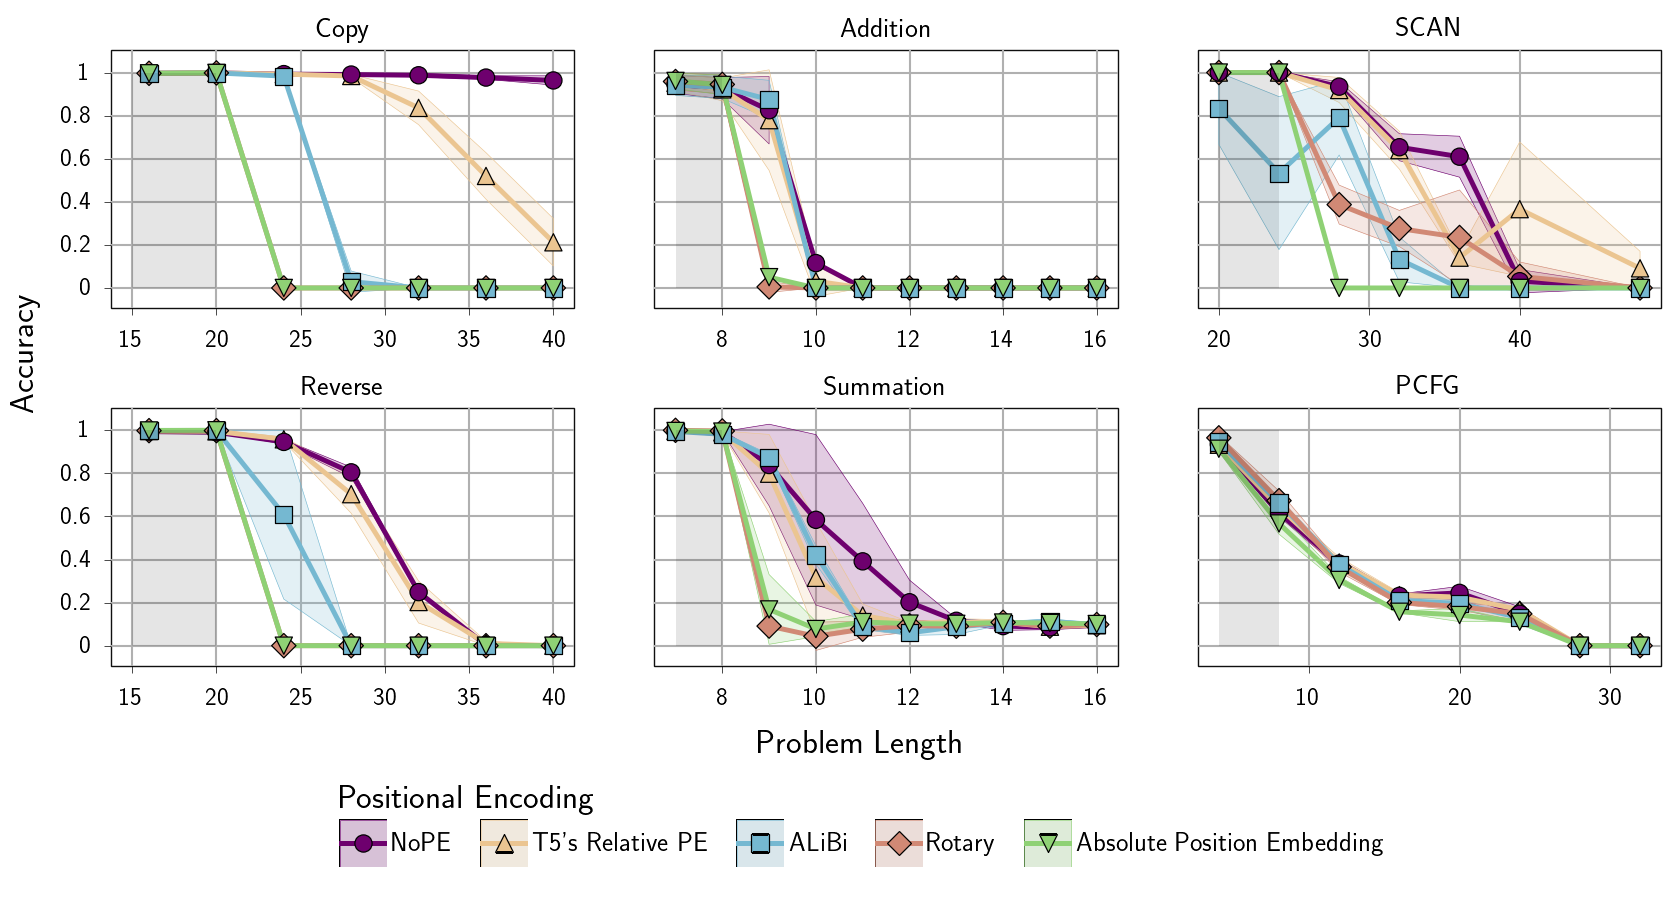

<ggplot: (8776612040930)>

In [17]:
import plotnine as p9

pdf = show_xdf.copy()
pdf = pdf[(pdf["seq_length"] != -1) & (pdf["output_acc"].isnull() == False)]


def fix_nope_name(pe_name):
    if pe_name.lower() == "no pe":
        return "NoPE"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding"
    if "T5" in pe_name:
        return "T5's Relative PE"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

print(pdf["pe"].unique())

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["NoPE", "T5's Relative PE", "ALiBi", "Rotary", "Absolute Position Embedding"]
)

pdf["dataset_pretty"] = pdf["dataset_pretty"].astype("category")
pdf["dataset_pretty"] = pdf["dataset_pretty"].cat.reorder_categories(
    ["Copy","Addition", "SCAN","Reverse", "Summation", "PCFG"]
)
show_xdf_max_valid_len["dataset_pretty"] = show_xdf_max_valid_len["dataset_pretty"].astype("category")
show_xdf_max_valid_len["dataset_pretty"] = show_xdf_max_valid_len["dataset_pretty"].cat.reorder_categories(
    ["Copy","Addition", "SCAN","Reverse", "Summation", "PCFG"]
)



max_validation_length = pdf[pdf["prediction_split"] == "validation"]["seq_length"].max()

# pdf = pdf[(pdf["seq_length"]+1) % 2 == 0]

p9u = importlib.reload(p9u)
p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y="output_acc"))
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe", color="pe"),
        alpha=0.2,
#         color="#A6A6A6",
        size=0.25,
        outline_type="full",
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
#         stat="summary",
    )
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe"),
#         size=1.1,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
#         mapping=p9.aes(fill="pe", color="pe", linetype="pe"),
        size=2,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
    + p9.geom_point(
        mapping=p9.aes(
            fill="pe",
            shape="pe",
#             color="pe",
        ),
        size=6.5,
#         color="#000",
        stroke=0.5,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_rect(
        data=show_xdf_max_valid_len, 
        mapping=p9.aes(xmin="min_len", xmax="max_valid_length",x="min_len",y=0),
        ymin=0,
        ymax=1,
        alpha=0.1, 
        fill="black",
    )
    # + p9.annotate("rect", xmin=4, xmax=19, ymin=0, ymax=1, alpha=0.1, fill="black", size=0.4)
    # + p9.annotate("text", x=12, y=0.5, label="I.I.D", size=23)
    # + p9.scale_x_continuous(limits=[4, 41], breaks=np.arange(0, 45, 4),)
    + p9.scale_y_continuous(breaks=np.arange(0, 1.1, 0.2), limits=[-0.04, 1.05])
    + p9.labs(
        x="Problem Length",
        y="Accuracy ",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9.facet_wrap("~dataset_pretty", ncol=3, scales="free_x")
#     + p9u.scale_fill_prism("FB_bellsprout2")
#     + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
        base_size=24, axis_text_size=18,
    )
    + p9.theme(
        #             plot_margin=0,
        strip_text_x=p9.element_text(size=20),
        strip_margin_y=0,
        panel_spacing_x=0.8,
        panel_spacing_y=0.55,
        legend_position="bottom",
        legend_box_spacing=0.9,
        legend_entry_spacing=20,
        panel_grid_major=p9.element_line(size=1.5),
        panel_border=p9.element_rect(fill="None", color="#0F0F0F", size=1),
        figure_size=(20, 8),
    )
)
p.save(output_dir / f"showcase.pdf")
p

## Appendix Figures

In [20]:
fig_1 = [
    # ("s2s_addition", "len_tr8_ts16", "i1_c0_o1_v1_r1", "Addition", 7, 1),
    # ("s2s_sum", "len_tr8_ts16", "i1_c0_o1_v1_r1", "Summation", 7, 1),
    ("s2s_addition", "len_tr8_ts16", "no_scratchpad", "Addition", 1, 1),
    ("s2s_sum", "len_tr8_ts16", "no_scratchpad", "Summation", 2, 1),
        ("s2s_parity", "len_tr8_ts16", "no_scratchpad", "Parity", 4, 1),
    ("s2s_sort", "len_sngd_tr8_ts16", "no_scratchpad", r"Sorting (\textit{Single Token})", 2, 1),
    ("s2s_sort", "len_mltd_tr8_ts16", "no_scratchpad", r"Sorting (\textit{Multi Token})", 2, 1),
    ("s2s_poly", "n_terms_tr8_ts16", "no_scratchpad", "Polynomial Evaluation", 1, 1),
    ("s2s_lego", "len_tr8_ts16", "no_scratchpad", "LEGO", 4, 1),
#     ("scan", "mdlen_tr25_ts48", "no_scratchpad", "SCAN", 1, 1),
#     ("pcfg", "md_productivity", "no_scratchpad", "PCFG", 1, 1),
]

fig_2 = [
    ("s2s_copy", "rsc_tr20_ts40", "no_scratchpad", r"Copy (\textit{Variant 1})", 1, 1),
    ("s2s_copy", "rsc2x_tr20_ts40", "no_scratchpad", r"Copy (\textit{Variant 1 (2x)})", 1, 1),
    ("s2s_copy", "rdc_tr20_ts40", "no_scratchpad", r"Copy (\textit{Variant 2})", 1, 1),
    ("s2s_copy", "cmc_tr20_ts40", "no_scratchpad", r"Copy (\textit{Variant 3})", 1, 1),
    ("s2s_copy", "cmc2x_tr20_ts40", "no_scratchpad", r"Copy (\textit{Variant 3 (2x)})", 1, 1),
    ("s2s_reverse", "mc_tr20_ts40", "no_scratchpad", r"Reverse (\textit{Variant 1})", 1, 1),
    ("s2s_reverse", "mc2x_tr20_ts40", "no_scratchpad", r"Reverse (\textit{Variant 1 (2x)})", 1, 1),
    ("s2s_reverse", "mcrv_tr20_ts40", "no_scratchpad", r"Reverse (\textit{Variant 2})", 1, 1),
    # ("s2s_addition", "len_tr8_ts16", "i1_c0_o1_v1_r1", "Addition", 7, 1),
    # ("s2s_sum", "len_tr8_ts16", "i1_c0_o1_v1_r1", "Summation", 7, 1),
]

fig_3 = [
    # ("s2s_addition", "len_tr8_ts16", "i1_c0_o1_v1_r1", "Addition", 7, 1),
    # ("s2s_sum", "len_tr8_ts16", "i1_c0_o1_v1_r1", "Summation", 7, 1),
    ("scan", "mdlen_tr25_ts48", "no_scratchpad", "SCAN", 1, 1),
    ("pcfg", "md_productivity", "no_scratchpad", "PCFG", 1, 1),
]

### Figure 1

In [ ]:
show_xdf, show_xdf_max_valid_len = get_showcase_df_all(fig_1)
len(show_xdf)

['Rotary' 'ALiBi' "T5's Relative PE" 'Absolute Position Embedding' 'NoPE']


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 16 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/showcase_final/appendix_showcase_1.pdf
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_a

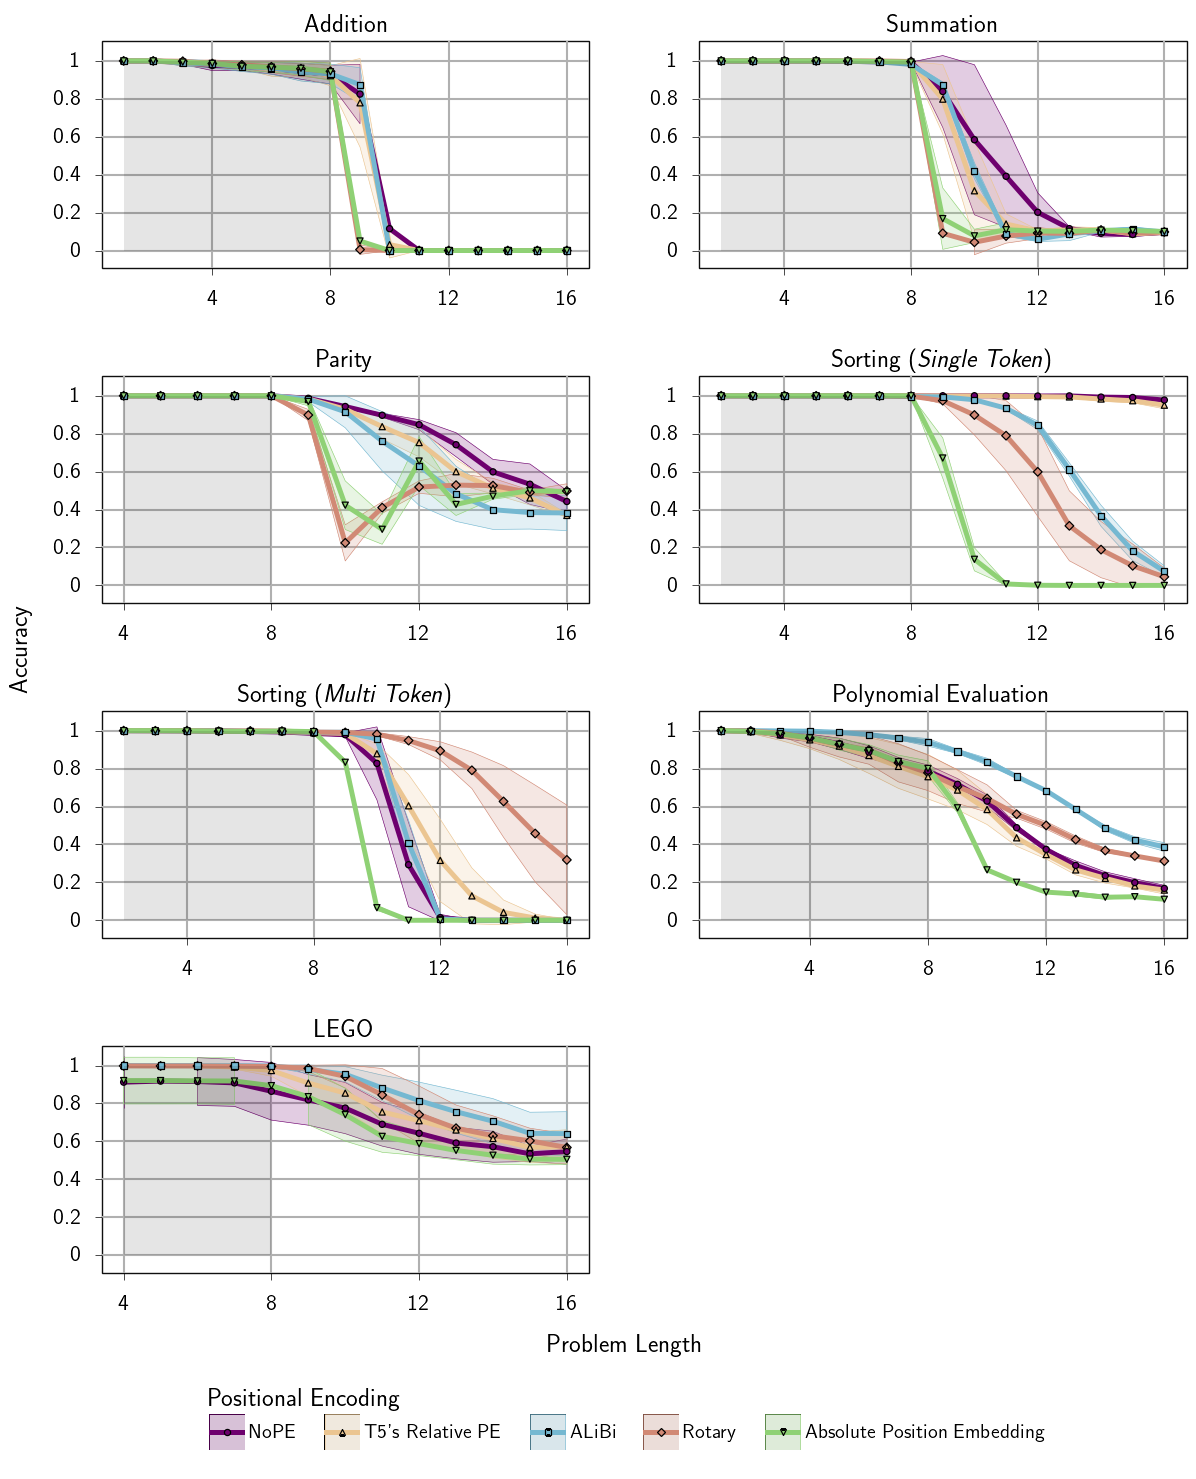

<ggplot: (8776835203856)>

In [64]:
import plotnine as p9

pdf = show_xdf.copy()
pdf = pdf[(pdf["seq_length"] != -1) & (pdf["output_acc"].isnull() == False)]


def fix_nope_name(pe_name):
    if pe_name.lower() == "no pe":
        return "NoPE"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding"
    if "T5" in pe_name:
        return "T5's Relative PE"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

print(pdf["pe"].unique())

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["NoPE", "T5's Relative PE", "ALiBi", "Rotary", "Absolute Position Embedding"]
)
pdf["dataset_pretty"] = pdf["dataset_pretty"].astype("category")
show_xdf_max_valid_len["dataset_pretty"] = show_xdf_max_valid_len["dataset_pretty"].astype("category")

fig_order = [f[3] for f in fig_1]
pdf["dataset_pretty"] = pdf["dataset_pretty"].cat.reorder_categories(
    fig_order
)
show_xdf_max_valid_len["dataset_pretty"] = show_xdf_max_valid_len["dataset_pretty"].cat.reorder_categories(
    fig_order
)



max_validation_length = pdf[pdf["prediction_split"] == "validation"]["seq_length"].max()

# pdf = pdf[(pdf["seq_length"]+1) % 2 == 0]

p9u = importlib.reload(p9u)
p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y="output_acc"))
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe", color="pe"),
        alpha=0.2,
#         color="#A6A6A6",
        size=0.25,
        outline_type="full",
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
#         stat="summary",
    )
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe"),
#         size=1.1,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
#         mapping=p9.aes(fill="pe", color="pe", linetype="pe"),
        size=2,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
    + p9.geom_point(
        mapping=p9.aes(
            fill="pe",
            shape="pe",
#             color="pe",
        ),
        size=2,
#         color="#000",
        stroke=0.5,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_rect(
        data=show_xdf_max_valid_len,
        mapping=p9.aes(xmin="min_len", xmax="max_valid_length",x="min_len",y=0),
        ymin=0,
        ymax=1,
        alpha=0.1,
        fill="black",
    )
    # + p9.annotate("rect", xmin=4, xmax=19, ymin=0, ymax=1, alpha=0.1, fill="black", size=0.4)
    # + p9.annotate("text", x=12, y=0.5, label="I.I.D", size=23)
    # + p9.scale_x_continuous(limits=[4, 41], breaks=np.arange(0, 45, 4),)
    + p9.scale_y_continuous(breaks=np.arange(0, 1.1, 0.2), limits=[-0.04, 1.05])
    + p9.labs(
        x="Problem Length",
        y="Accuracy ",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9.facet_wrap("~dataset_pretty", ncol=2, scales="free")
#     + p9u.scale_fill_prism("FB_bellsprout2")
#     + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
        base_size=18, axis_text_size=16,
    )
    + p9.theme(
        #             plot_margin=0,
        strip_text_x=p9.element_text(size=18),
        strip_margin_y=0,
        panel_spacing_x=1.1,
        panel_spacing_y=0.7,
        legend_position="bottom",
        legend_box_spacing=0.9,
        legend_entry_spacing=20,
        panel_grid_major=p9.element_line(size=1.5),
        panel_border=p9.element_rect(fill="None", color="#0F0F0F", size=1),
        figure_size=(14, 16),
    )
)
p.save(output_dir / f"appendix_showcase_1.pdf")
p

### Figure 2

In [32]:
show_xdf, show_xdf_max_valid_len = get_showcase_df_all(fig_2)
len(show_xdf)

/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_17305/3297188249.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_17305/3297188249.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_17305/3297188249.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

585
585
585
585


/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_17305/3297188249.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_17305/3297188249.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_17305/3297188249.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

585
585
585
585


/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_17305/3297188249.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4680

['Rotary' 'Absolute Position Embedding' "T5's Relative PE" 'ALiBi' 'NoPE']


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 16 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/showcase_final/appendix_showcase_2.pdf
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_a

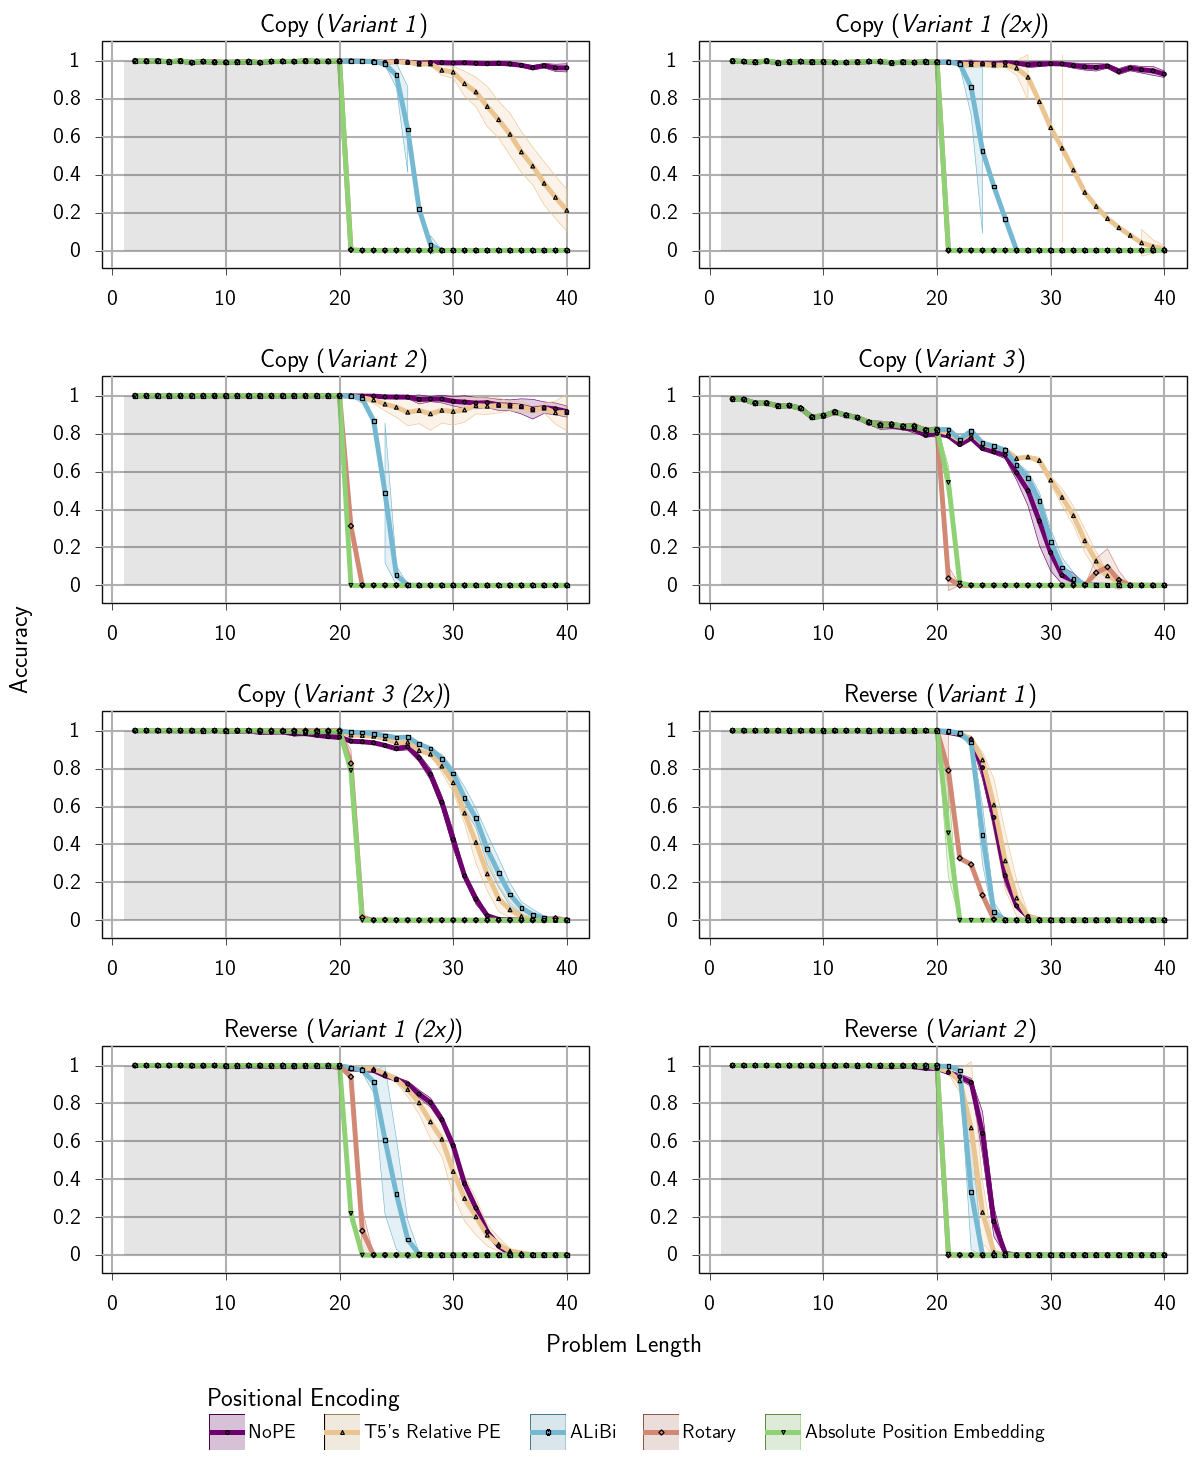

<ggplot: (8762736819225)>

In [33]:
import plotnine as p9

pdf = show_xdf.copy()
pdf = pdf[(pdf["seq_length"] != -1) & (pdf["output_acc"].isnull() == False)]


def fix_nope_name(pe_name):
    if pe_name.lower() == "no pe":
        return "NoPE"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding"
    if "T5" in pe_name:
        return "T5's Relative PE"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

print(pdf["pe"].unique())

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["NoPE", "T5's Relative PE", "ALiBi", "Rotary", "Absolute Position Embedding"]
)
pdf["dataset_pretty"] = pdf["dataset_pretty"].astype("category")
show_xdf_max_valid_len["dataset_pretty"] = show_xdf_max_valid_len["dataset_pretty"].astype("category")

fig_order = [f[3] for f in fig_2]
pdf["dataset_pretty"] = pdf["dataset_pretty"].cat.reorder_categories(
    fig_order
)
show_xdf_max_valid_len["dataset_pretty"] = show_xdf_max_valid_len["dataset_pretty"].cat.reorder_categories(
    fig_order
)



max_validation_length = pdf[pdf["prediction_split"] == "validation"]["seq_length"].max()

# pdf = pdf[(pdf["seq_length"]+1) % 2 == 0]

p9u = importlib.reload(p9u)
p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y="output_acc"))
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe", color="pe"),
        alpha=0.2,
#         color="#A6A6A6",
        size=0.25,
        outline_type="full",
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
#         stat="summary",
    )
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe"),
#         size=1.1,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
#         mapping=p9.aes(fill="pe", color="pe", linetype="pe"),
        size=2,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
    + p9.geom_point(
        mapping=p9.aes(
            fill="pe",
            shape="pe",
#             color="pe",
        ),
        size=1,
#         color="#000",
        stroke=0.5,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_rect(
        data=show_xdf_max_valid_len,
        mapping=p9.aes(xmin="min_len", xmax="max_valid_length",x="min_len",y=0),
        ymin=0,
        ymax=1,
        alpha=0.1,
        fill="black",
    )
    # + p9.annotate("rect", xmin=4, xmax=19, ymin=0, ymax=1, alpha=0.1, fill="black", size=0.4)
    # + p9.annotate("text", x=12, y=0.5, label="I.I.D", size=23)
    # + p9.scale_x_continuous(limits=[4, 41], breaks=np.arange(0, 45, 4),)
    + p9.scale_y_continuous(breaks=np.arange(0, 1.1, 0.2), limits=[-0.04, 1.05])
    + p9.labs(
        x="Problem Length",
        y="Accuracy ",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9.facet_wrap("~dataset_pretty", ncol=2, scales="free")
#     + p9u.scale_fill_prism("FB_bellsprout2")
#     + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
        base_size=18, axis_text_size=16,
    )
    + p9.theme(
        #             plot_margin=0,
        strip_text_x=p9.element_text(size=18),
        strip_margin_y=0,
        panel_spacing_x=1.1,
        panel_spacing_y=0.7,
        legend_position="bottom",
        legend_box_spacing=0.9,
        legend_entry_spacing=20,
        panel_grid_major=p9.element_line(size=1.5),
        panel_border=p9.element_rect(fill="None", color="#0F0F0F", size=1),
        figure_size=(14, 16),
    )
)
p.save(output_dir / f"appendix_showcase_2.pdf")
p

### Figure 3

In [23]:
show_xdf, show_xdf_max_valid_len = get_showcase_df_all(fig_3)
len(show_xdf)

480
480


/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_17305/3297188249.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_17305/3297188249.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


960

['Rotary' 'ALiBi' "T5's Relative PE" 'NoPE' 'Absolute Position Embedding']


/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 14 x 3.1 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/showcase_final/appendix_showcase_3.pdf
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


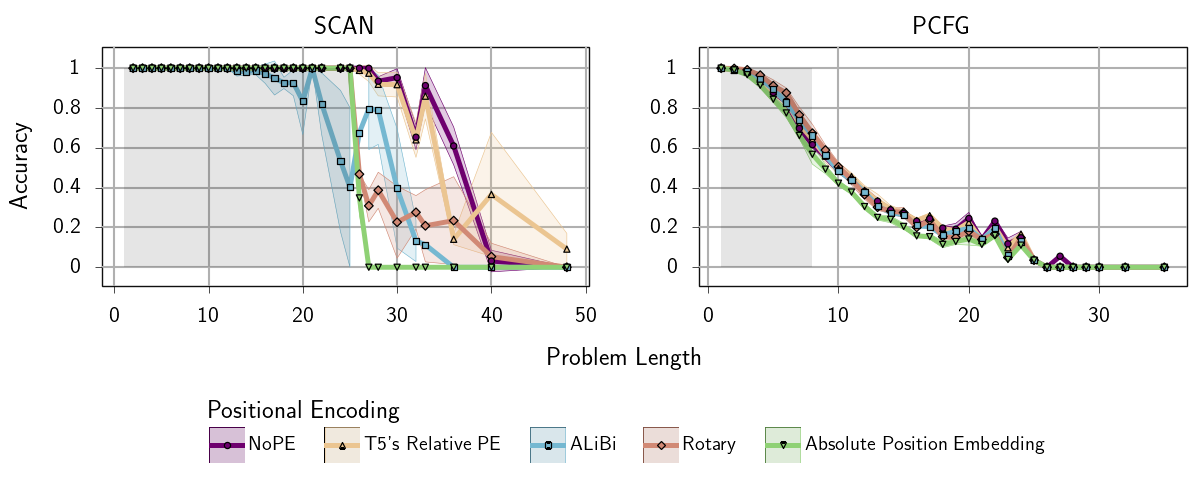

<ggplot: (8762741479518)>

In [31]:
import plotnine as p9

pdf = show_xdf.copy()
pdf = pdf[(pdf["seq_length"] != -1) & (pdf["output_acc"].isnull() == False)]


def fix_nope_name(pe_name):
    if pe_name.lower() == "no pe":
        return "NoPE"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding"
    if "T5" in pe_name:
        return "T5's Relative PE"
    return pe_name
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

print(pdf["pe"].unique())

pdf["pe"] = pdf["pe"].astype("category")
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["NoPE", "T5's Relative PE", "ALiBi", "Rotary", "Absolute Position Embedding"]
)
pdf["dataset_pretty"] = pdf["dataset_pretty"].astype("category")
show_xdf_max_valid_len["dataset_pretty"] = show_xdf_max_valid_len["dataset_pretty"].astype("category")

fig_order = [f[3] for f in fig_3]
pdf["dataset_pretty"] = pdf["dataset_pretty"].cat.reorder_categories(
    fig_order
)
show_xdf_max_valid_len["dataset_pretty"] = show_xdf_max_valid_len["dataset_pretty"].cat.reorder_categories(
    fig_order
)



max_validation_length = pdf[pdf["prediction_split"] == "validation"]["seq_length"].max()

# pdf = pdf[(pdf["seq_length"]+1) % 2 == 0]

p9u = importlib.reload(p9u)
p = (
    p9.ggplot(pdf, p9.aes(x="seq_length", y="output_acc"))
    + p9.geom_ribbon(
        p9.aes(ymin=p9.after_stat("ymin"), ymax=p9.after_stat("ymax"), fill="pe", color="pe"),
        alpha=0.2,
#         color="#A6A6A6",
        size=0.25,
        outline_type="full",
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
#         stat="summary",
    )
    + p9.geom_line(
        mapping=p9.aes(fill="pe", color="pe"),
#         size=1.1,
        # stat=p9.stat_summary(fun_data="mean_sdl", geom="geom_line")
#         mapping=p9.aes(fill="pe", color="pe", linetype="pe"),
        size=2,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
        #             stat=p9.stat_summary(mapping=p9.aes(y="output_acc"), geom="geom_line")
    )
    + p9.geom_point(
        mapping=p9.aes(
            fill="pe",
            shape="pe",
#             color="pe",
        ),
        size=2,
#         color="#000",
        stroke=0.5,
        stat=p9.stat_summary(fun_data="mean_sdl", fun_args={"mult": 1}),
    )
    + p9.geom_rect(
        data=show_xdf_max_valid_len,
        mapping=p9.aes(xmin="min_len", xmax="max_valid_length",x="min_len",y=0),
        ymin=0,
        ymax=1,
        alpha=0.1,
        fill="black",
    )
    # + p9.annotate("rect", xmin=4, xmax=19, ymin=0, ymax=1, alpha=0.1, fill="black", size=0.4)
    # + p9.annotate("text", x=12, y=0.5, label="I.I.D", size=23)
    # + p9.scale_x_continuous(limits=[4, 41], breaks=np.arange(0, 45, 4),)
    + p9.scale_y_continuous(breaks=np.arange(0, 1.1, 0.2), limits=[-0.04, 1.05])
    + p9.labs(
        x="Problem Length",
        y="Accuracy ",
        color="Positional Encoding",
        fill="Positional Encoding",
        shape="Positional Encoding",
    )
    + p9.facet_wrap("~dataset_pretty", ncol=2, scales="free")
#     + p9u.scale_fill_prism("FB_bellsprout2")
#     + p9u.scale_color_prism("FB_bellsprout2")
#     + p9.theme_minimal()
    + p9u.scale_fill_prism("formal")
    + p9u.scale_color_prism("formal")
    + p9u.theme_formal(
        base_family="Computer Modern Sans serif",
        grid="YX",
        base_size=18, axis_text_size=16,
    )
    + p9.theme(
        #             plot_margin=0,
        strip_text_x=p9.element_text(size=18),
        strip_margin_y=0,
        panel_spacing_x=1.1,
        panel_spacing_y=0.7,
        legend_position="bottom",
        legend_box_spacing=0.9,
        legend_entry_spacing=20,
        panel_grid_major=p9.element_line(size=1.5),
        panel_border=p9.element_rect(fill="None", color="#0F0F0F", size=1),
        figure_size=(14, 3.1),
    )
)
p.save(output_dir / f"appendix_showcase_3.pdf")
p

## Poster

## Appendix Scratchpad

In [18]:
def get_scratchpad_showcase_df_all(ds, ds_split):
    show_df_lst = []
    max_valid_lengths = []
    show_conf = [f for f in scratchpad_fig if f[0] == ds and f[1] == ds_split]
    for ds, ds_split, sctch_config, ds_pretty, min_len, mod in show_conf:
        xxdf = xdf[
            (xdf["ds"] == ds)
            & (xdf["ds_split"] == ds_split)
            & (xdf["seq_length"] == -1)
            & (xdf["prediction_split"] == "test")
            & (xdf["output_acc"].isnull() == False)
        ]
        xxdf["dataset_pretty"] = ds_pretty
        print(len(xxdf))

        # Get max validation length
        # max_len = xxdf[xxdf["prediction_split"] == "validation"]["seq_length"].max()
        # max_valid_lengths.append(
        #     {
        #         "ds": ds,
        #         "dataset_pretty": ds_pretty,
        #         "max_valid_length": max_len,
        #         "min_len": min_len,
        #         "x": min_len,
        #         "y": 0,
        #     }
        # )
        show_df_lst.append(xxdf)

    return pd.concat(show_df_lst, ignore_index=True)

scratchpad_fig = [
    ("s2s_addition", "len_tr8_ts16", "no_scratchpad", "Addition", 1, 1),
    ("s2s_sum", "len_tr8_ts16", "no_scratchpad", "Summation", 2, 1),
    ("s2s_parity", "len_tr8_ts16", "no_scratchpad", "Parity", 4, 1),
    ("s2s_sort", "len_sngd_tr8_ts16", "no_scratchpad", r"Sorting (\textit{Single Token})", 2, 1),
    ("s2s_sort", "len_mltd_tr8_ts16", "no_scratchpad", r"Sorting (\textit{Multi Token})", 2, 1),
    ("s2s_poly", "n_terms_tr8_ts16", "no_scratchpad", "Polynomial Evaluation", 1, 1),
    ("s2s_lego", "len_tr8_ts16", "no_scratchpad", "LEGO", 4, 1),
]

/var/folders/1v/7yt3f78s4xq7g51lj7r4v9800000gn/T/ipykernel_18179/2268350511.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 6 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/showcase_final/avg_acc_per_scrhConfig2____.pdf


120


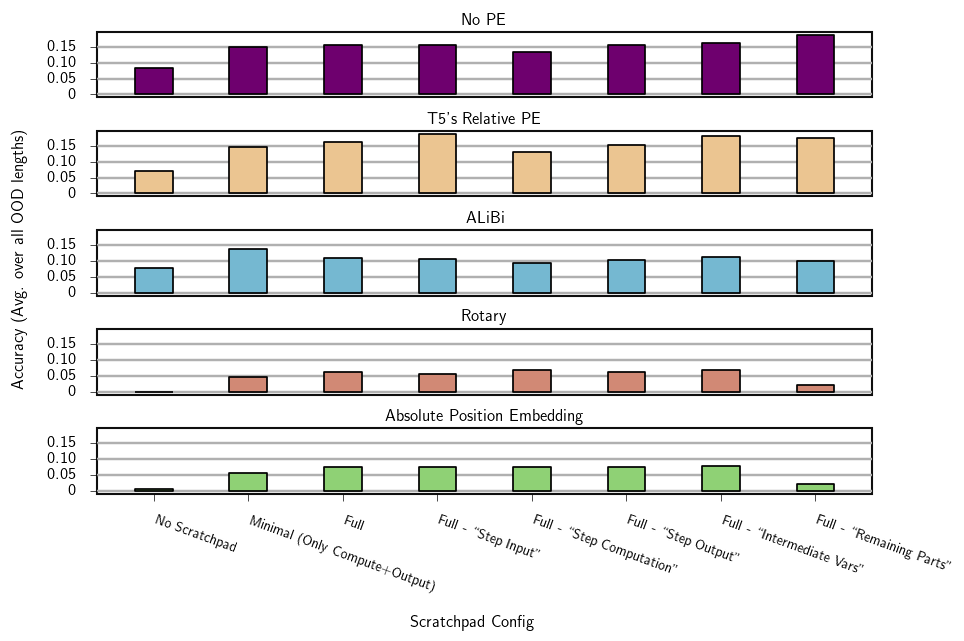

<ggplot: (8783847525617)>

In [59]:
import plotnine as p9
pdf = get_scratchpad_showcase_df_all("s2s_addition", "len_tr8_ts16")
pdf = pdf.copy()

# pdf = xdf[(xdf["seq_length"] != -1) & (xdf["seq_length"] >= 9) & (xdf["seq_length"] <= 16) & (xdf["output_acc"].isnull() == False)]

pdf["scratchpad_config"] = pdf.apply(
    wandb_utils.df_prettify_scratchpad_config_name,
    axis=1
)

existing_configs = set(pdf["scratchpad_config"].unique().tolist())
config_order = [pe for pe in wandb_utils.get_pretty_scratchpad_config_order2() if pe in existing_configs]
pdf["scratchpad_config"] = pdf["scratchpad_config"].astype("category")
pdf["scratchpad_config"] = pdf["scratchpad_config"].cat.reorder_categories(config_order)

def fix_scratchpad_config_name(sc_name):
    return sc_name.replace("Removing ", "Full - ").replace(' "', ' ``').replace('"', "''")
    
pdf["scratchpad_config"] = pdf["scratchpad_config"].apply(fix_scratchpad_config_name)

p9u = importlib.reload(p9u)


def fix_nope_name(pe_name):
    if pe_name.lower() == "no pe":
        return "No PE"
    if pe_name.lower() == "absolute sinusoid":
        return "Absolute Position Embedding"
    if "t5" in pe_name.lower():
        return "T5's Relative PE"
    return pe_name

# Fix pe names
pdf["pe"] = pdf.apply(lambda x: wandb_utils.get_pretty_pe_name(x["pe"]), axis=1)
pdf["pe"] = pdf["pe"].apply(fix_nope_name)

existing_pes = set(pdf["pe"].unique().tolist())
pe_order = [pe for pe in wandb_utils.get_pretty_pe_order() if pe in existing_pes]
pdf["pe"] = pdf["pe"].astype("category")
# pdf["pe"] = pdf["pe"].cat.reorder_categories(pe_order)
pdf["pe"] = pdf["pe"].cat.reorder_categories(
    ["No PE", "T5's Relative PE", "ALiBi", "Rotary", "Absolute Position Embedding"]
)

p = (
        p9.ggplot(pdf, p9.aes(x="scratchpad_config", y="output_acc", fill="pe", color="pe"))
        + p9.geom_col(
            stat="summary", position='dodge',
            color="black",
            size=0.7,
            width=0.4,
        )
        + p9.facet_wrap("pe", ncol=1)
#         + p9.coord_flip)
        # + p9.scale_x_continuous(breaks=np.arange(7, 17), limits=[7,13])
        + p9.labs(x="Scratchpad Config", y="Accuracy (Avg. over all OOD lengths)", fill="Positional Encoding", shape="Positional Encoding", color="Positional Encoding")
        # )
#         + p9u.scale_fill_prism("FB_bellsprout")
        + p9u.scale_fill_prism("formal")
#         + p9.scale_y_continuous(limits = (0, 0.9),expand = (0, 0))
        + p9u.theme_formal(
            base_family="Computer Modern Sans serif",
            grid="Y",
             base_size=14, axis_text_size=12, strip_text_size=12,
            axis_title_size=12
        )
        + p9.theme(
            # #             plot_margin=0,
    #                     text=p9.element_text(size=20),
#                         legend_box_spacing=0.7,
    #                     legend_entry_spacing=40,
                        legend_position="none",
#             legend_text=p9.element_text(size=28),
    #                     legend_box="vertical",
#             panel_spacing=0.8,
            figure_size=(10, 6),
            axis_text_x=p9.element_text(rotation=-20, hjust=0, size=10)
        )
    )
p.save(output_dir / f"avg_acc_per_scrhConfig2____.pdf")
p